In [ ]:
#Assignment

In [1]:
import numpy as np # linear algebra

In [2]:
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [3]:
from sklearn.model_selection import train_test_split # function for splitting data to train and test sets

In [4]:
import nltk

In [5]:
from nltk.corpus import stopwords

In [6]:
from nltk.classify import SklearnClassifier

In [7]:
from wordcloud import WordCloud,STOPWORDS
import matplotlib.pyplot as plt

In [35]:
Sentiment = pd.read_csv(r"S:\COMP_318_Developing UI for Software Devices\Social Media Sentiment Analysis\Sentiment.csv")

In [66]:
data = Sentiment[['text','sentiment']]

In [44]:
test = pd.read_csv(r"S:\COMP_318_Developing UI for Software Devices\Social Media Sentiment Analysis\test.csv")

In [45]:
print("Test Set:"% test.columns, test.shape, len(test))

Test Set: (17197, 2) 17197


In [46]:
train = pd.read_csv(r"S:\COMP_318_Developing UI for Software Devices\Social Media Sentiment Analysis\train.csv")

In [47]:
print("Training Set:"% train.columns, train.shape, len(train))

Training Set: (31962, 3) 31962


In [48]:
#Data Cleaning
import re

In [49]:
def  clean_text(df, text_field):
    df[text_field] = df[text_field].str.lower()
    df[text_field] = df[text_field].apply(lambda elem: re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", elem))  
    return df
test_clean = clean_text(test, "tweet")
train_clean = clean_text(train, "tweet")

In [50]:
#Handling Imbalanced data for Hate Speech Detection Model
from sklearn.utils import resample
train_majority = train_clean[train_clean.label==0]
train_minority = train_clean[train_clean.label==1]
train_minority_upsampled = resample(train_minority, 
                                 replace=True,    
                                 n_samples=len(train_majority),   
                                 random_state=123)
train_upsampled = pd.concat([train_minority_upsampled, train_majority])
train_upsampled['label'].value_counts()

0    29720
1    29720
Name: label, dtype: int64

In [51]:
#Creating a Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDClassifier
pipeline_sgd = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf',  TfidfTransformer()),
    ('nb', SGDClassifier()),])

In [52]:
#Training the Hate Speech Detection Model
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_upsampled['tweet'],
                                                    train_upsampled['label'],random_state = 0)

In [53]:
#train the model and predict the results on the test set using the F1 score method:
model = pipeline_sgd.fit(X_train, y_train)
y_predict = model.predict(X_test)
from sklearn.metrics import f1_score
f1_score(y_test, y_predict)

0.9699192956713132

In [67]:
# Splitting the dataset into train and test set
train, test = train_test_split(data,test_size = 0.1)
# Removing neutral sentiments
train = train[train.sentiment != "Neutral"]

In [68]:
train_pos = train[ train['sentiment'] == 'Positive']
train_pos = train_pos['text']
train_neg = train[ train['sentiment'] == 'Negative']
train_neg = train_neg['text']


In [69]:
def wordcloud_draw(data, color = 'black'):
    words = ' '.join(data)
    cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and not word.startswith('#')
                                and word != 'RT'
                            ])
    wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color=color,
                      width=2500,
                      height=2000
                     ).generate(cleaned_word)
    plt.figure(1,figsize=(13, 13))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

In [70]:
print("Positive words")

Positive words


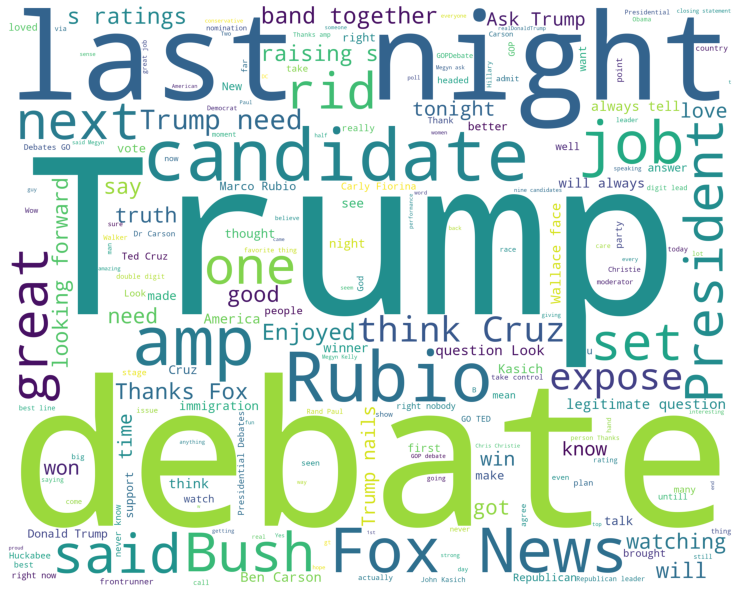

In [73]:
wordcloud_draw(train_pos,'white')

In [74]:
print("Negative words")

Negative words


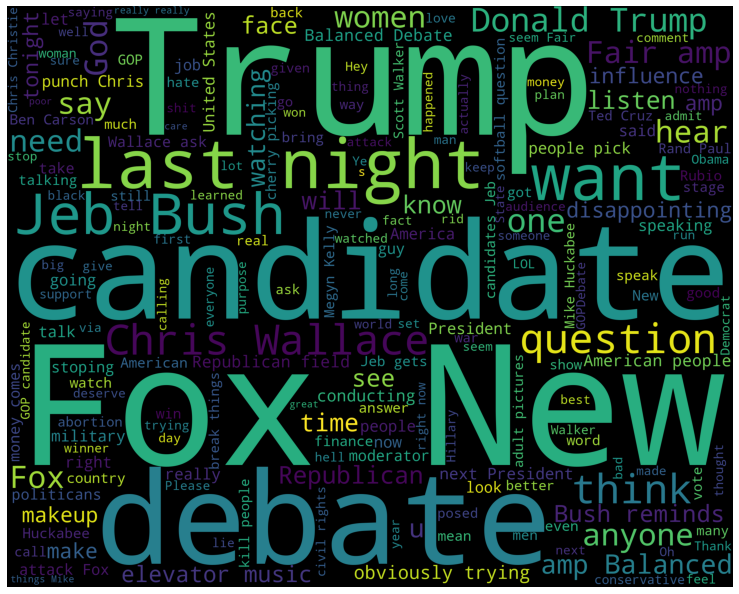

In [75]:
wordcloud_draw(train_neg)

In [76]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [77]:
tweets = []
stopwords_set = set(stopwords.words("english"))

In [78]:
for index, row in train.iterrows():
    words_filtered = [e.lower() for e in row.text.split() if len(e) >= 3]
    words_cleaned = [word for word in words_filtered
        if 'http' not in word
        and not word.startswith('@')
        and not word.startswith('#')
        and word != 'RT']
    words_without_stopwords = [word for word in words_cleaned if not word in stopwords_set]
    tweets.append((words_without_stopwords, row.sentiment))

In [79]:
test_pos = test[ test['sentiment'] == 'Positive']
test_pos = test_pos['text']
test_neg = test[ test['sentiment'] == 'Negative']
test_neg = test_neg['text']

In [80]:
# Extracting word features
def get_words_in_tweets(tweets):
    all = []
    for (words, sentiment) in tweets:
        all.extend(words)
    return all

In [81]:
def get_word_features(wordlist):
    wordlist = nltk.FreqDist(wordlist)
    features = wordlist.keys()
    return features
w_features = get_word_features(get_words_in_tweets(tweets))

def extract_features(document):
    document_words = set(document)
    features = {}
    for word in w_features:
        features['contains(%s)' % word] = (word in document_words)
    return features

In [ ]:
# Training the Naive Bayes classifier
training_set = nltk.classify.apply_features(extract_features,tweets)
classifier = nltk.NaiveBayesClassifier.train(training_set)

In [ ]:
neg_cnt = 0
pos_cnt = 0
for obj in test_neg: 
    res =  classifier.classify(extract_features(obj.split()))
    if(res == 'Negative'): 
        neg_cnt = neg_cnt + 1
for obj in test_pos: 
    res =  classifier.classify(extract_features(obj.split()))
    if(res == 'Positive'): 
        pos_cnt = pos_cnt + 1

In [ ]:
print('[Negative]: %s/%s '  % (len(test_neg),neg_cnt))  

In [ ]:
print('[Positive]: %s/%s '  % (len(test_pos),pos_cnt))